# Cat v Dogs

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print('PyTorch Version: ', torch.__version__)
print('Torchvision Version: ', torchvision.__version__)

PyTorch Version:  2.0.1
Torchvision Version:  0.15.2


## Hyper parameters

In [2]:
batch_size = 8

num_epochs = 5

num_classes = 2

## M1 Mac Optimisation

In [3]:
# Run on M1 chip
device = torch.device('mps')

## Init the model

In [4]:
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224

/Users/ludwig/google-drive/DD2424-Deep-Learning-in-Data-Science/Project/project-venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ludwig/google-drive/DD2424-Deep-Learning-in-Data-Science/Project/project-venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Testing the model

## Augmentatinos

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Load the data

In [6]:
data_dir = 'Dataset/dog_v_cat'

folders = ['train', 'val', 'test']

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in folders}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in folders}


## Print model

In [7]:
# Send the model to GPU
model_ft = model.to(device)

params_to_update = model_ft.parameters()
print('All params in the network:')
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print('\t', name)

All params in the network:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsampl

In [8]:
def unfreeze_layers_and_update_optimizer(model, layers_to_unfreeze, learning_rate):
    """Freeze all but the specified layers of the model and return updated optimizer"""
    
    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Initialize params_to_update
    params_to_update = []

    # Unfreeze the specified layers
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_unfreeze):
            if '.bn' in name:
                print(f'not unfreezing: {name}')
                continue
            print(f'unfreezing: {name}')
            param.requires_grad = True
            params_to_update.append(param)
    
    optimizer = optim.AdamW(params_to_update, lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, max_lr=learning_rate * 10, cycle_momentum=False)
    return optimizer, scheduler

## Train the model

Epoch 1/5
Train Loss: 0.2339 Acc: 0.9025
Val Loss: 0.0309 Acc: 0.9982
Epoch 2/5
Train Loss: 0.1727 Acc: 0.9293
Val Loss: 0.0136 Acc: 0.9973
Epoch 3/5
Train Loss: 0.1847 Acc: 0.9297
Val Loss: 0.0129 Acc: 0.9964
Epoch 4/5
Train Loss: 0.1713 Acc: 0.9320
Val Loss: 0.0095 Acc: 0.9973
Epoch 5/5
Train Loss: 0.1797 Acc: 0.9320
Val Loss: 0.0080 Acc: 0.9982
Training complete in 5m 54s
Best val Acc: 0.998190


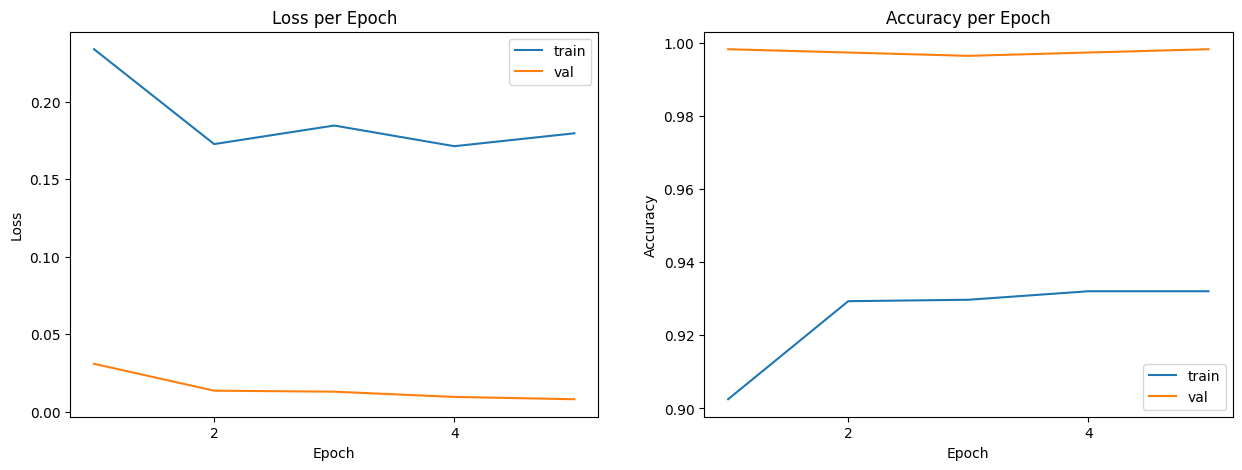

In [9]:
class Trainer:
    def __init__(self, model, criterion, dataloaders, device, num_epochs=25, learning_rate=0.001, layers_to_unfreeze=['fc']):
        self.model = model
        self.criterion = criterion
        self.dataloaders = dataloaders
        self.device = device
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.layers_to_unfreeze = layers_to_unfreeze

        self.optimizer = self.unfreeze_layers_and_update_optimizer()

        self.train_acc_history = []
        self.train_loss_history = []
        self.val_acc_history = []
        self.val_loss_history = []

        self.best_model_wts = copy.deepcopy(model.state_dict())
        self.best_acc = 0.0
        self.start_time = time.time()

    def unfreeze_layers_and_update_optimizer(self):
        for name, child in self.model.named_children():
            if name in self.layers_to_unfreeze:
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False

        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.learning_rate)
        return optimizer

    def train(self):
        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch + 1, self.num_epochs))
            self.train_one_epoch(epoch)
            self.validate(epoch)

        self.finalize_training()

    def train_one_epoch(self, epoch):
        self.model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in self.dataloaders['train']:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(self.dataloaders['train'].dataset)
        epoch_acc = running_corrects.float() / len(self.dataloaders['train'].dataset)

        self.train_acc_history.append(epoch_acc.item())
        self.train_loss_history.append(epoch_loss)

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    def validate(self, epoch):
        self.model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in self.dataloaders['val']:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            with torch.no_grad():
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(self.dataloaders['val'].dataset)
        epoch_acc = running_corrects.float() / len(self.dataloaders['val'].dataset)

        if epoch_acc > self.best_acc:
            self.best_acc = epoch_acc
            self.best_model_wts = copy.deepcopy(self.model.state_dict())

        self.val_acc_history.append(epoch_acc.item())
        self.val_loss_history.append(epoch_loss)

        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    def plot_histories(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        epochs = range(1, self.num_epochs+1)
        even_epochs = [epoch for epoch in epochs if epoch % 2 == 0]

        ax1.plot(epochs, self.train_loss_history, label='train')
        ax1.plot(epochs, self.val_loss_history, label='val')
        ax1.set_title('Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_xticks(even_epochs)
        ax1.legend()

        ax2.plot(epochs, self.train_acc_history, label='train')
        ax2.plot(epochs, self.val_acc_history, label='val')
        ax2.set_title('Accuracy per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_xticks(even_epochs)
        ax2.legend()

        plt.show()

    def finalize_training(self):
        time_elapsed = time.time() - self.start_time
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(self.best_acc))

        self.model.load_state_dict(self.best_model_wts)
        self.plot_histories()


criterion = torch.nn.CrossEntropyLoss()

trainer = Trainer(
    model=model,
    criterion=criterion,
    dataloaders=dataloaders,
    device=device,
    num_epochs=num_epochs,
    learning_rate=0.001,
    layers_to_unfreeze=['fc']
)

trainer.train()

## Test the model

In [10]:
model.eval()

running_loss = 0.0
running_corrects = 0

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

epoch_loss = running_loss / len(dataloaders['test'].dataset)
epoch_acc = running_corrects.float() / len(dataloaders['test'].dataset)

print('Testing the model\n')
print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))

Testing the model

test Loss: 0.0372 Acc: 0.9951
